<a href="https://colab.research.google.com/github/umar-faroooq/Jupyter-notebooks/blob/main/3_settings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [ ]:
csv_path = '/content/drive/MyDrive/LSTM Implementation/AHUF5/preprocessed_AHUF5.csv'
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df.pop('Timestamp'))


In [ ]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
hour,184556.0,11.481442,6.996583,0.00,5.000000,11.000000,18.000000,23.00
day,184556.0,2.983674,2.049272,0.00,1.000000,3.000000,5.000000,6.00
OAT,184556.0,29.578779,4.235406,19.97,26.432292,29.019776,32.603375,43.57
SAT,184556.0,21.532370,6.854144,0.00,18.100000,21.300000,27.100000,34.30
RH,184556.0,56.528214,18.727590,0.00,49.000000,59.000000,70.000000,91.00
CHW_Temp,184556.0,19.317503,7.275348,0.00,15.700000,18.800000,23.600000,34.00
Valve,184556.0,38.702481,48.552425,0.00,0.000000,0.000000,100.000000,100.00
RAT,184556.0,27.146891,6.456997,0.00,27.500000,28.300000,29.300000,35.70


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='RAT', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['RAT'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['RAT']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  print(model.summary())
  print(history)
  

# Setting 1
  With one LSTM layers. Multistep forecasting with single output

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [ ]:
history = compile_and_fit(lstm_model, wide_window)
# print(history.summary())



Epoch 1/20
4037/4037 [==============================] - 69s 17ms/step - loss: 0.0172 - mean_absolute_error: 0.0304 - val_loss: 0.0042 - val_mean_absolute_error: 0.0114
Epoch 2/20
4037/4037 [==============================] - 67s 17ms/step - loss: 0.0037 - mean_absolute_error: 0.0102 - val_loss: 0.0044 - val_mean_absolute_error: 0.0104
Epoch 3/20
4037/4037 [==============================] - 68s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0098 - val_loss: 0.0049 - val_mean_absolute_error: 0.0114
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 24, 32)            5248      
                                                                 
 dense_8 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
__________

In [ ]:
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=1)

576/576 [==============================] - 4s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0098


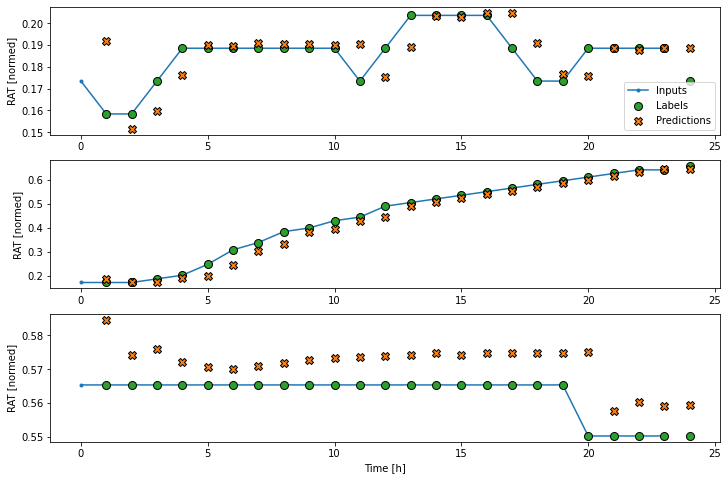

In [ ]:
wide_window.plot(lstm_model)


# Setting 2
With two LSTM layers.
Multistep forecasting with single output

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model2, wide_window)
# print(history.summary())


Epoch 1/20
4037/4037 [==============================] - 134s 32ms/step - loss: 0.0111 - mean_absolute_error: 0.0242 - val_loss: 0.0043 - val_mean_absolute_error: 0.0131
Epoch 2/20
4037/4037 [==============================] - 129s 32ms/step - loss: 0.0036 - mean_absolute_error: 0.0119 - val_loss: 0.0047 - val_mean_absolute_error: 0.0117
Epoch 3/20
4037/4037 [==============================] - 130s 32ms/step - loss: 0.0033 - mean_absolute_error: 0.0100 - val_loss: 0.0050 - val_mean_absolute_error: 0.0092
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 24, 64)            18688     
                                                                 
 lstm_12 (LSTM)              (None, 24, 32)            12416     
                                                                 
 dense_9 (Dense)             (None, 24, 1)             33        
         

In [ ]:
val2_performance = {}
performance2 = {}
IPython.display.clear_output()
val2_performance['LSTM'] = lstm_model2.evaluate(wide_window.val)
performance2['LSTM'] = lstm_model2.evaluate(wide_window.test, verbose=1)

576/576 [==============================] - 6s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0105


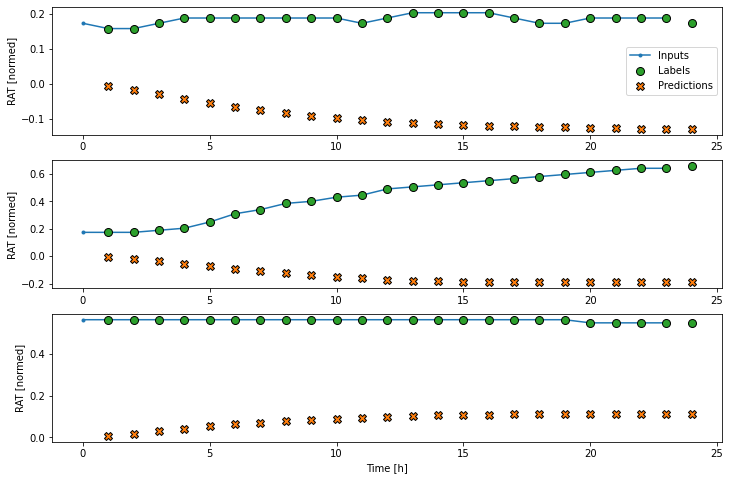

In [ ]:
wide_window.plot(lstm_model2)


# Setting 03 
With two LSTM layers and one Time Distributed Layer. Multistep forecasting with single output 

In [ ]:
# tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
lstm_model3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

In [ ]:
history = compile_and_fit(lstm_model3, wide_window)

Epoch 1/20
4037/4037 [==============================] - 134s 32ms/step - loss: 0.0133 - mean_absolute_error: 0.0261 - val_loss: 0.0048 - val_mean_absolute_error: 0.0162
Epoch 2/20
4037/4037 [==============================] - 129s 32ms/step - loss: 0.0035 - mean_absolute_error: 0.0113 - val_loss: 0.0050 - val_mean_absolute_error: 0.0106
Epoch 3/20
4037/4037 [==============================] - 128s 32ms/step - loss: 0.0033 - mean_absolute_error: 0.0097 - val_loss: 0.0051 - val_mean_absolute_error: 0.0113
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 24, 64)            18688     
                                                                 
 lstm_16 (LSTM)              (None, 24, 32)            12416     
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 1)            33        
 tribute

In [ ]:
val3_performance = {}
performance3 = {}
IPython.display.clear_output()
val3_performance['LSTM'] = lstm_model3.evaluate(wide_window.val)
performance3['LSTM'] = lstm_model3.evaluate(wide_window.test, verbose=1)

576/576 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0089


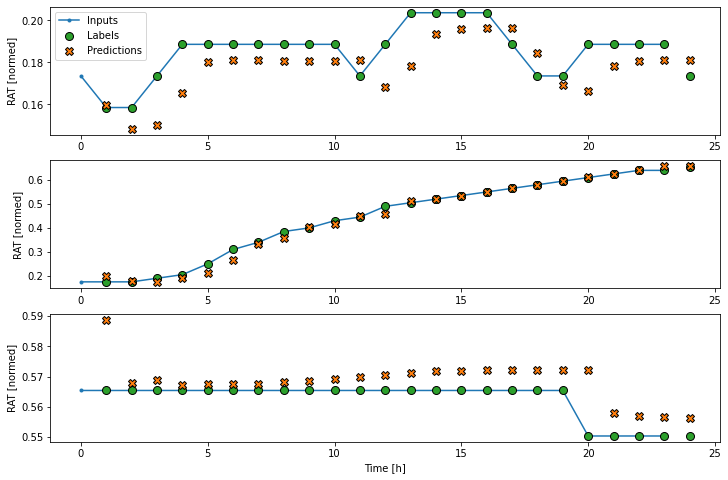

In [ ]:
wide_window.plot(lstm_model3)
